#### Housekeeping

In [102]:
%reset -f

import pandas as pd
import numpy as np
# import folium   
import os
# import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 16})
from matplotlib.transforms import ScaledTranslation
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.ticker import AutoLocator
import seaborn as sns

import nrarfcn as nr
# https://gitlab.com/alexander_marder/earfcn
# https://pypi.org/project/earfcn/0.0.3/
from earfcn.convert import earfcn2freq

##### Bokeh plot function

In [103]:
import geopandas as gpd
from bokeh.plotting import figure, output_notebook, show, output_file
output_notebook()
from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar, HoverTool, WheelZoomTool, WMTSTileSource
from bokeh.palettes import Viridis256

Loading BokehJS ...

In [104]:
def plot_geo_scatter_map(df, value_col, title="Geo Map", colorbar_title="Value", unit=""):
    # Create GeoDataFrame and project to Web Mercator
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs="EPSG:4326").to_crs("EPSG:3857")
    gdf['x'], gdf['y'] = gdf.geometry.x, gdf.geometry.y

    # Setup Bokeh figure
    p = figure(
        title=title, width=800, height=500,
        x_axis_type="mercator", y_axis_type="mercator",
        tools="pan,reset,save",
        x_range=(gdf['x'].min()-300, gdf['x'].max()+300),
        y_range=(gdf['y'].min()-300, gdf['y'].max()+300)
    )
    p.add_tools(WheelZoomTool(zoom_on_axis=False))
    p.add_tile(WMTSTileSource(
        url='https://cartodb-basemaps-4.global.ssl.fastly.net/light_all/{Z}/{X}/{Y}.png',
        attribution="© CartoDB contributors")
    )

    # Color mapping and data source
    color_mapper = LinearColorMapper(palette=Viridis256, low=gdf[value_col].min(), high=gdf[value_col].max())
    source = ColumnDataSource(gdf[['x', 'y', value_col, 'Latitude', 'Longitude']])

    # Scatter points
    p.scatter(
        x='x', y='y', size=5, source=source,
        fill_color={'field': value_col, 'transform': color_mapper},
        line_color=None, fill_alpha=0.7
    )

    # Color bar and hover
    p.add_layout(ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title=colorbar_title), 'right')
    p.add_tools(HoverTool(tooltips=[
        ("Lat/Lon", "@{Latitude}, @{Longitude}"),
        (value_col, f"@{{{value_col}}} {unit}")
    ]))

    p.toolbar.active_drag = None
    p.toolbar.active_inspect = None

    show(p)

In [105]:
def plot_geo_binned_map(df, value_col, title="Geo Map", colorbar_title="Value", unit="", step_num=1e4):

    step_deg = step_num / 111.32e3  # convert meters to degrees
    to_bin = lambda x: np.floor(x / step_deg) * step_deg
    df = df.copy()
    df['lat_bin'] = to_bin(df['Latitude'])
    df['lon_bin'] = to_bin(df['Longitude'])
    binned = df.groupby(['lat_bin', 'lon_bin'])[value_col].max().reset_index()
    # binned = df.groupby(['lat_bin', 'lon_bin'])[value_col].mean().reset_index()
    def latlon_to_webm(lat, lon):
        k = 6378137
        x = k * np.radians(lon)
        y = k * np.log(np.tan(np.pi / 4 + np.radians(lat) / 2))
        return x, y
    binned['lat_max'] = binned['lat_bin'] + step_deg
    binned['lon_max'] = binned['lon_bin'] + step_deg
    x0, y0 = latlon_to_webm(binned['lat_bin'].values, binned['lon_bin'].values)
    x1, y1 = latlon_to_webm(binned['lat_max'].values, binned['lon_max'].values)
    binned['x0'], binned['x1'] = x0, x1
    binned['y0'], binned['y1'] = y0, y1

    # Setup Bokeh figure
    p = figure(
        title=title, width=800, height=500,
        x_axis_type="mercator", y_axis_type="mercator",
        tools="pan,reset,save",
        x_range=(min(x0)-100, max(x1)+100),
        y_range=(min(y0)-100, max(y1)+100)
    )
    p.add_tools(WheelZoomTool(zoom_on_axis=False))
    p.add_tile(WMTSTileSource(
        url='https://cartodb-basemaps-4.global.ssl.fastly.net/light_all/{Z}/{X}/{Y}.png',
        attribution="© CartoDB contributors")
    )

    # Color mapping and data source
    # color_mapper = LinearColorMapper(palette=Viridis256, low=binned[value_col].min(), high=binned[value_col].max())
    color_mapper = LinearColorMapper(palette=Viridis256, low=-135, high=-65)
    source = ColumnDataSource(binned)

    # Draw rectangles for each bin
    p.quad(
        top='y1', bottom='y0', left='x0', right='x1',
        source=source,
        fill_color={'field': value_col, 'transform': color_mapper},
        line_color=None, fill_alpha=0.7
    )

    # Color bar and hover
    p.add_layout(ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title=colorbar_title), 'right')
    p.add_tools(HoverTool(tooltips=[
        ("Lat Bin", "@lat_bin"),
        ("Lon Bin", "@lon_bin"),
        (value_col, f"@{{{value_col}}} {unit}")
    ]))

    p.toolbar.active_drag = None
    p.toolbar.active_inspect = None

    show(p)

In [106]:
def save_geo_binned_map(df, value_col, title="Geo Map", colorbar_title="Value", unit="", step_num=1e4, bounds=None):

    step_deg = step_num / 111.32e3  # convert meters to degrees
    to_bin = lambda x: np.floor(x / step_deg) * step_deg
    df = df.copy()
    df['lat_bin'] = to_bin(df['Latitude'])
    df['lon_bin'] = to_bin(df['Longitude'])
    binned = df.groupby(['lat_bin', 'lon_bin'])[value_col].max().reset_index()
    # binned = df.groupby(['lat_bin', 'lon_bin'])[value_col].mean().reset_index()
    def latlon_to_webm(lat, lon):
        k = 6378137
        x = k * np.radians(lon)
        y = k * np.log(np.tan(np.pi / 4 + np.radians(lat) / 2))
        return x, y
    binned['lat_max'] = binned['lat_bin'] + step_deg
    binned['lon_max'] = binned['lon_bin'] + step_deg
    x0, y0 = latlon_to_webm(binned['lat_bin'].values, binned['lon_bin'].values)
    x1, y1 = latlon_to_webm(binned['lat_max'].values, binned['lon_max'].values)
    binned['x0'], binned['x1'] = x0, x1
    binned['y0'], binned['y1'] = y0, y1

    if bounds:
        x_range = bounds[0]
        y_range = bounds[1]
    else:
        x_range = (min(x0) - 40, max(x1) + 40)
        y_range = (min(y0) - 40, max(y1) + 40)
        print(f"x_range: {x_range}")
        print(f"y_range: {y_range}")

    # Setup Bokeh figure
    p = figure(
        # title=title, ### FOR TITLE
        width=650, height=500,
        x_axis_type="mercator", y_axis_type="mercator",
        tools="pan,reset,save",
        x_range=x_range,
        y_range=y_range
    )

    p.add_tools(WheelZoomTool(zoom_on_axis=False))
    p.add_tile(WMTSTileSource(
        url='https://cartodb-basemaps-4.global.ssl.fastly.net/light_all/{Z}/{X}/{Y}.png',
        attribution="© CartoDB contributors")
    )
    # p.add_tile(WMTSTileSource(
    #     url='https://tile.openstreetmap.org/{Z}/{X}/{Y}.png',
    #     attribution="© OpenStreetMap contributors"),
    #     retina=True
    # )

    # Color mapping and data source
    # color_mapper = LinearColorMapper(palette=Viridis256, low=binned[value_col].min(), high=binned[value_col].max())
    color_mapper = LinearColorMapper(palette=Viridis256, low=-135, high=-65)
    source = ColumnDataSource(binned)

    # Draw rectangles for each bin
    p.quad(
        top='y1', bottom='y0', left='x0', right='x1',
        source=source,
        fill_color={'field': value_col, 'transform': color_mapper},
        line_color=None, fill_alpha=0.7
    )

    # Color bar and hover
    p.add_layout(ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0, 0), title=colorbar_title, title_text_font_size="20pt", major_label_text_font_size="18pt"), 'right')
    p.add_tools(HoverTool(tooltips=[
        ("Lat Bin", "@lat_bin"),
        ("Lon Bin", "@lon_bin"),
        (value_col, f"@{{{value_col}}} {unit}")
    ]))

    p.toolbar.active_drag = None
    p.toolbar.active_inspect = None

    p.xaxis.visible = False
    p.yaxis.visible = False

    output_file("binned_map.html")
    show(p)

##### Read Data

In [107]:
df_5g_radio = pd.read_csv('../_data/Spring2025_ArkansasNH/5g_radio.csv', sep=';')

df_lte_radio = pd.read_csv('../_data/Spring2025_ArkansasNH/lte_radio.csv', sep=';')

#### 5G-LTE Combining Shared Channel

In [108]:
# Frequency calculation processing

df_5g_radio['DL Freq'] = df_5g_radio['DL NR-ARFCN'].apply(nr.get_frequency)
df_5g_radio['DL Freq'] = df_5g_radio['DL Freq'].round(-1)

df_lte_radio['DL Freq'] = df_lte_radio['DL EARFCN'].apply(earfcn2freq)
df_lte_radio['DL Freq'] = df_lte_radio['DL Freq'].round(-1)

#### Radio

##### Data cleaning & map plotting

In [109]:
print(df_lte_radio['Collection'].value_counts().sort_index())

Collection
Day1-ATT-MNO-DEF-IN       2393
Day1-ATT-MNO-DEF-OUT      3344
Day1-ATT-NH-IN            1714
Day1-ATT-NH-OUT            524
Day1-TMO-MNO-DEF-IN       1143
Day1-TMO-NH-IN            3015
Day1-TMO-NH-OUT            469
Day2-ATT-MNO-4G-IN        2931
Day2-ATT-MNO-4G-OUT       4826
Day2-ATT-MNO-DEF-IN       3384
Day2-ATT-MNO-DEF-OUT      3198
Day2-ATT-MNO-DEF-OUTER    2820
Day2-TMO-MNO-4G-IN        2996
Day2-TMO-MNO-4G-OUT       3134
Day2-VZN-MNO-4G-IN        5507
Day2-VZN-MNO-4G-OUT       2757
Day2-VZN-MNO-DEF-IN       3671
Day2-VZN-MNO-DEF-OUT      1867
Day2-VZN-MNO-DEF-OUTER    2700
Day3_ATT-MNO-DEF-IN-L1    2590
Day3_ATT-MNO-DEF-IN-L2    2437
Day3_ATT-NH-IN-L1          822
Day3_ATT-NH-IN-L2         1436
Day3_TMO-DEF-L1-V1          84
Day3_TMO-NH-L1            1686
Day3_TMO-NH-L2             742
Day3_unnamed               283
Name: count, dtype: int64


In [110]:
df_lte_radio_att_nh_in = df_lte_radio[df_lte_radio['Collection']=='Day1-ATT-NH-IN']
df_lte_radio_att_nh_out = df_lte_radio[df_lte_radio['Collection']=='Day1-ATT-NH-OUT']

df_lte_radio_att_mno_in = pd.concat([df_lte_radio[df_lte_radio['Collection']=='Day1-ATT-MNO-DEF-IN'],
                                    df_lte_radio[df_lte_radio['Collection']=='Day2-ATT-MNO-4G-IN'],
                                    df_lte_radio[df_lte_radio['Collection']=='Day2-ATT-MNO-DEF-IN']],
                                    ignore_index=True)
df_lte_radio_att_mno_out = pd.concat([df_lte_radio[df_lte_radio['Collection']=='Day1-ATT-MNO-DEF-OUT'],
                                    df_lte_radio[df_lte_radio['Collection']=='Day2-ATT-MNO-4G-OUT'],
                                    df_lte_radio[df_lte_radio['Collection']=='Day2-ATT-MNO-DEF-OUT']],
                                    # df_lte_radio[df_lte_radio['Collection']=='Day2-ATT-MNO-DEF-OUTER']],
                                    ignore_index=True)

df_lte_radio_tmo_nh_in = df_lte_radio[df_lte_radio['Collection']=='Day1-TMO-NH-IN']
df_lte_radio_tmo_nh_out = df_lte_radio[df_lte_radio['Collection']=='Day1-TMO-NH-OUT']

df_lte_radio_tmo_mno_in = pd.concat([df_lte_radio[df_lte_radio['Collection']=='Day1-TMO-MNO-DEF-IN'],
                                    df_lte_radio[df_lte_radio['Collection']=='Day2-TMO-MNO-4G-IN']],
                                    ignore_index=True)
df_lte_radio_tmo_mno_out = df_lte_radio[df_lte_radio['Collection']=='Day2-TMO-MNO-4G-OUT']

df_lte_radio_vzn_mno_in = pd.concat([df_lte_radio[df_lte_radio['Collection']=='Day2-VZN-MNO-4G-IN'],
                                    df_lte_radio[df_lte_radio['Collection']=='Day2-VZN-MNO-DEF-IN']],
                                    ignore_index=True)
df_lte_radio_vzn_mno_out = pd.concat([df_lte_radio[df_lte_radio['Collection']=='Day2-VZN-MNO-4G-OUT'],
                                    df_lte_radio[df_lte_radio['Collection']=='Day2-VZN-MNO-DEF-OUT']],
                                    # df_lte_radio[df_lte_radio['Collection']=='Day2-VZN-MNO-DEF-OUTER']],
                                    ignore_index=True)

In [111]:
print(df_5g_radio['Collection'].value_counts().sort_index())

Collection
Day1-TMO-MNO-DEF-IN       36757
Day1-TMO-MNO-DEF-OUT      20564
Day2-TMO-MNO-DEF-IN       16745
Day2-TMO-MNO-DEF-OUT      19916
Day2-TMO-MNO-DEF-OUTER    16908
Day2-VZN-MNO-DEF-IN        2521
Day2-VZN-MNO-DEF-OUT       2988
Day2-VZN-MNO-DEF-OUTER     3372
Day3_TMO-DEF-IN-L2         1052
Day3_TMO-DEF-L1-V1         1486
Day3_TMO-DEF-L2             783
Name: count, dtype: int64


In [112]:
df_5g_radio_tmo_mno_in = pd.concat([df_5g_radio[df_5g_radio['Collection']=='Day1-TMO-MNO-DEF-IN'],
                                    df_5g_radio[df_5g_radio['Collection']=='Day2-TMO-MNO-DEF-IN']],
                                    ignore_index=True)
df_5g_radio_tmo_mno_out = pd.concat([df_5g_radio[df_5g_radio['Collection']=='Day1-TMO-MNO-DEF-OUT'],
                                    df_5g_radio[df_5g_radio['Collection']=='Day2-TMO-MNO-DEF-OUT']],
                                    # df_5g_radio[df_5g_radio['Collection']=='Day2-TMO-MNO-DEF-OUTER']],
                                    ignore_index=True)

df_5g_radio_vzn_mno_in = df_5g_radio[df_5g_radio['Collection']=='Day2-VZN-MNO-DEF-IN']
df_5g_radio_vzn_mno_out = pd.concat([df_5g_radio[df_5g_radio['Collection']=='Day2-VZN-MNO-DEF-OUT']],
                                    # df_5g_radio[df_5g_radio['Collection']=='Day2-VZN-MNO-DEF-OUTER']],
                                    ignore_index=True)

##### Map plotting

In [113]:
# temp = pd.concat([df_lte_radio_att_nh_in, df_lte_radio_att_nh_out, df_lte_radio_tmo_nh_in, df_lte_radio_tmo_nh_out])
# save_geo_binned_map(temp, value_col="RSRP", title="MNO NH ", colorbar_title="RSRP (dBm)", unit="dBm", step_num=6, bounds=[(-10484692.040246455, -10484312.041618733), (4327365.312535497, 4327742.706441018)])
# del temp

# temp = pd.concat([df_lte_radio_att_mno_in, df_lte_radio_att_mno_out, df_lte_radio_tmo_mno_in, df_lte_radio_tmo_mno_out, df_lte_radio_vzn_mno_in, df_lte_radio_vzn_mno_out])
# save_geo_binned_map(temp, value_col="RSRP", title="MNO Ma LTE ", colorbar_title="RSRP (dBm)", unit="dBm", step_num=6, bounds=[(-10484692.040246455, -10484312.041618733), (4327365.312535497, 4327742.706441018)])
# del temp

# temp = pd.concat([df_5g_radio_tmo_mno_in, df_5g_radio_tmo_mno_out, df_5g_radio_vzn_mno_in, df_5g_radio_vzn_mno_out])
# save_geo_binned_map(temp, value_col="SS-RSRP", title="MNO Ma NR ", colorbar_title="SS-RSRP (dBm)", unit="dBm", step_num=6, bounds=[(-10484692.040246455, -10484312.041618733), (4327365.312535497, 4327742.706441018)])
# del temp

##### print(): Statistics summary

In [114]:
print('LTE ATT NH IN')
print(df_lte_radio_att_nh_in[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())
print('LTE ATT NH OUT')
print(df_lte_radio_att_nh_out[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())
print('LTE ATT MNO IN')
print(df_lte_radio_att_mno_in[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())
print('LTE ATT MNO OUT')
print(df_lte_radio_att_mno_out[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())

LTE ATT NH IN
Band Number  DL Freq  DL Bandwidth
48           3560.0   20.0            378
             3590.0   20.0            420
             3620.0   20.0             71
             3650.0   20.0            376
             3690.0   20.0            468
Name: count, dtype: int64
LTE ATT NH OUT
Band Number  DL Freq  DL Bandwidth
48           3560.0   20.0            228
             3590.0   20.0              3
             3620.0   20.0             27
             3650.0   20.0            236
             3690.0   20.0             30
Name: count, dtype: int64
LTE ATT MNO IN
Band Number  DL Freq  DL Bandwidth
2            1940.0   10.0            1964
                      15.0               1
             1980.0   10.0              12
                      15.0            2241
12           740.0    10.0            1327
                      15.0               1
14           760.0    10.0             609
                      15.0               1
30           2360.0   10.0         

In [115]:
print('LTE TMO NH IN')
print(df_lte_radio_tmo_nh_in[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())
print('LTE TMO NH OUT')
print(df_lte_radio_tmo_nh_out[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())
print('LTE TMO MNO IN')
print(df_lte_radio_tmo_mno_in[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())
print('LTE TMO MNO OUT')
print(df_lte_radio_tmo_mno_out[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())

LTE TMO NH IN
Band Number  DL Freq  DL Bandwidth
48           3560.0   20.0            713
             3590.0   20.0            693
             3620.0   20.0            108
             3650.0   20.0            707
             3690.0   20.0            793
Name: count, dtype: int64
LTE TMO NH OUT
Band Number  DL Freq  DL Bandwidth
48           3560.0   20.0            228
             3590.0   20.0              7
             3650.0   20.0            226
             3690.0   20.0              8
Name: count, dtype: int64
LTE TMO MNO IN
Band Number  DL Freq  DL Bandwidth
2            1930.0   5.0             1689
12           730.0    5.0              614
66           2140.0   20.0            1831
Name: count, dtype: int64
LTE TMO MNO OUT
Band Number  DL Freq  DL Bandwidth
2            1930.0   5.0              966
12           730.0    5.0              932
66           2140.0   20.0            1226
Name: count, dtype: int64


In [116]:
print('LTE VZN MNO IN')
print(df_lte_radio_vzn_mno_in[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())
print('LTE VZN MNO OUT')
print(df_lte_radio_vzn_mno_out[['Band Number', 'DL Freq', 'DL Bandwidth']].value_counts().sort_index())

LTE VZN MNO IN
Band Number  DL Freq  DL Bandwidth
2            1950.0   10.0            2121
5            880.0    10.0            1369
13           750.0    10.0            1348
66           2120.0   20.0            2375
             2160.0   10.0            1964
                      20.0               1
Name: count, dtype: int64
LTE VZN MNO OUT
Band Number  DL Freq  DL Bandwidth
2            1950.0   10.0             330
13           750.0    10.0            1251
66           2120.0   20.0            2030
             2160.0   10.0             598
Name: count, dtype: int64


In [117]:
print('5G TMO MNO IN')
print(df_5g_radio_tmo_mno_in[['Band Number', 'DL Freq']].value_counts().sort_index())
print('5G TMO MNO OUT')
print(df_5g_radio_tmo_mno_out[['Band Number', 'DL Freq']].value_counts().sort_index())
print('5G VZN MNO IN')
print(df_5g_radio_vzn_mno_in[['Band Number', 'DL Freq']].value_counts().sort_index())
print('5G VZN MNO OUT')
print(df_5g_radio_vzn_mno_out[['Band Number', 'DL Freq']].value_counts().sort_index())

5G TMO MNO IN
Band Number  DL Freq
25.0         630.0        100
             1960.0      8130
             1990.0      2695
41.0         630.0         41
             1960.0        18
             1990.0         2
             2510.0     17689
             2600.0     18945
71.0         630.0       5828
             1960.0        10
             2510.0        20
             2600.0        24
Name: count, dtype: int64
5G TMO MNO OUT
Band Number  DL Freq
25.0         1960.0      6201
             1990.0      1550
41.0         630.0          2
             1960.0         2
             2510.0     13019
             2600.0     15415
71.0         630.0       4291
Name: count, dtype: int64
5G VZN MNO IN
Band Number  DL Freq
77.0         3730.0     1321
             3810.0     1200
Name: count, dtype: int64
5G VZN MNO OUT
Band Number  DL Freq
77.0         3730.0     1530
             3810.0     1458
Name: count, dtype: int64


##### Plots: All Meas

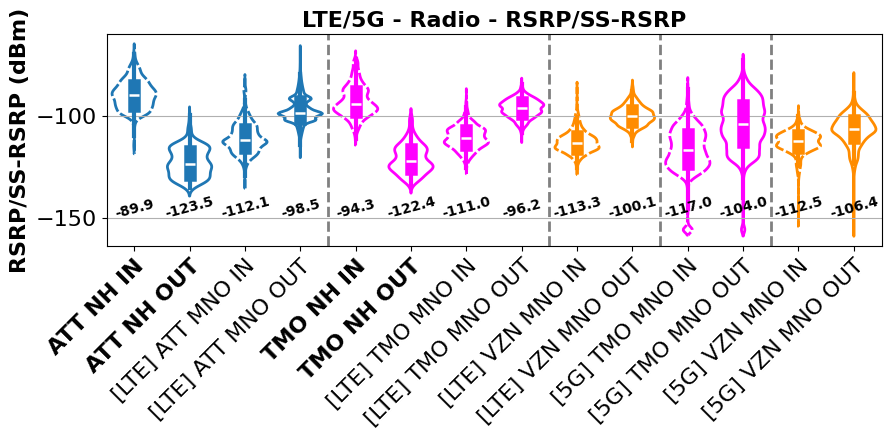

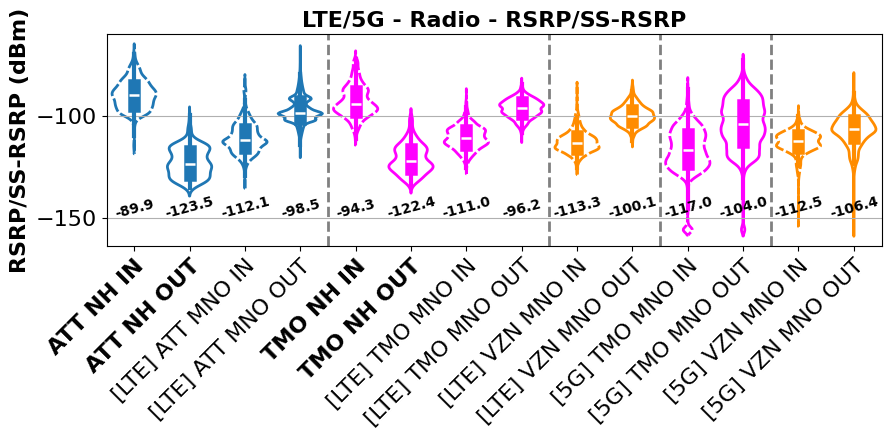

In [ ]:
# LTE/5G - Radio - RSRP/SS-RSRP
fig, ax = plt.subplots(figsize=(10, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_radio_att_nh_in.assign(Collection_plot='ATT NH IN'),
    df_lte_radio_att_nh_out.assign(Collection_plot='ATT NH OUT'),
    df_lte_radio_att_mno_in.assign(Collection_plot='[LTE] ATT MNO IN'),
    df_lte_radio_att_mno_out.assign(Collection_plot='[LTE] ATT MNO OUT'),
    df_lte_radio_tmo_nh_in.assign(Collection_plot='TMO NH IN'),
    df_lte_radio_tmo_nh_out.assign(Collection_plot='TMO NH OUT'),
    df_lte_radio_tmo_mno_in.assign(Collection_plot='[LTE] TMO MNO IN'),
    df_lte_radio_tmo_mno_out.assign(Collection_plot='[LTE] TMO MNO OUT'),
    df_lte_radio_vzn_mno_in.assign(Collection_plot='[LTE] VZN MNO IN'),
    df_lte_radio_vzn_mno_out.assign(Collection_plot='[LTE] VZN MNO OUT'),
    df_5g_radio_tmo_mno_in.rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='[5G] TMO MNO IN'),
    df_5g_radio_tmo_mno_out.rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='[5G] TMO MNO OUT'),
    df_5g_radio_vzn_mno_in.rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='[5G] VZN MNO IN'),
    df_5g_radio_vzn_mno_out.rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='[5G] VZN MNO OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='RSRP', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 14, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=3.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=7.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
medians = data.groupby('Collection_plot')['RSRP'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, -150, f'{median_value:.1f}', horizontalalignment='center', color='black', fontsize=10, fontweight='bold', rotation=15)

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT NH IN', 'ATT NH OUT', 'TMO NH IN', 'TMO NH OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RSRP/SS-RSRP (dBm)', fontsize=16, fontweight='bold')
plt.title('LTE/5G - Radio - RSRP/SS-RSRP', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/plot_radio_rsrp_all.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/plot_radio_rsrp_all.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_8901/4007393489.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right')


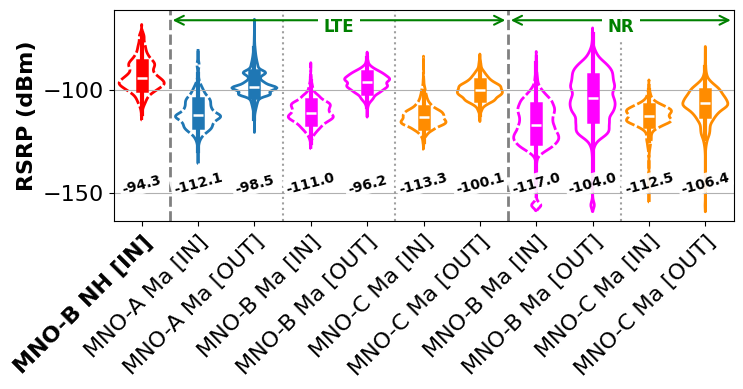

In [ ]:
# LTE/5G - Radio - RSRP/SS-RSRP
fig, ax = plt.subplots(figsize=(8, 2.75))
palette = ['red', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_radio_tmo_nh_in.assign(Collection_plot='TMO NH IN'),
    df_lte_radio_att_mno_in.assign(Collection_plot='[LTE] ATT MNO IN'),
    df_lte_radio_att_mno_out.assign(Collection_plot='[LTE] ATT MNO OUT'),
    df_lte_radio_tmo_mno_in.assign(Collection_plot='[LTE] TMO MNO IN'),
    df_lte_radio_tmo_mno_out.assign(Collection_plot='[LTE] TMO MNO OUT'),
    df_lte_radio_vzn_mno_in.assign(Collection_plot='[LTE] VZN MNO IN'),
    df_lte_radio_vzn_mno_out.assign(Collection_plot='[LTE] VZN MNO OUT'),
    df_5g_radio_tmo_mno_in.rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='[5G] TMO MNO IN'),
    df_5g_radio_tmo_mno_out.rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='[5G] TMO MNO OUT'),
    df_5g_radio_vzn_mno_in.rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='[5G] VZN MNO IN'),
    df_5g_radio_vzn_mno_out.rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='[5G] VZN MNO OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='RSRP', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
new_labels = ['MNO-B NH [IN]', 'MNO-A Ma [IN]', 'MNO-A Ma [OUT]', 'MNO-B Ma [IN]', 'MNO-B Ma [OUT]', 'MNO-C Ma [IN]', 'MNO-C Ma [OUT]', 'MNO-B Ma [IN]', 'MNO-B Ma [OUT]', 'MNO-C Ma [IN]', 'MNO-C Ma [OUT]']
ax.set_xticklabels(new_labels, rotation=45, ha='right')

ax.collections[0].set_linestyle((0,(5,1)))
ax.collections[1].set_linestyle((0,(5,1)))
ax.collections[3].set_linestyle((0,(5,1)))
ax.collections[5].set_linestyle((0,(5,1)))
ax.collections[7].set_linestyle((0,(5,1)))
ax.collections[9].set_linestyle((0,(5,1)))

plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=6.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=2.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=4.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=8.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)

medians = data.groupby('Collection_plot')['RSRP'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, -150, f'{medians[collection]:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

ax.annotate(
    '', xy=(6.5, 0.95), xytext=(0.5, 0.95),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(4/11, 0.92, 'LTE', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

ax.annotate(
    '', xy=(10.5, 0.95), xytext=(6.5, 0.95),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(9/11, 0.92, 'NR', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['MNO-B NH [IN]']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RSRP (dBm)', fontsize=16, fontweight='bold')
# plt.title('LTE/5G - Radio - RSRP/SS-RSRP', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/radio-all-rsrp.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

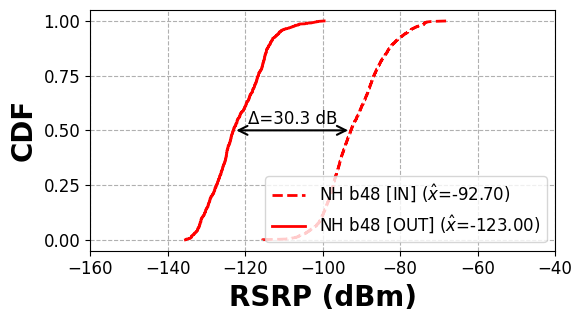

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3.5))
plt.rcParams['text.usetex'] = False 

df_temp = data = pd.concat([df_lte_radio_att_nh_in,df_lte_radio_tmo_nh_in])['RSRP'].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"NH b48 [IN] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='dashed', color='red')
del df_temp

df_temp = data = pd.concat([df_lte_radio_att_nh_out,df_lte_radio_tmo_nh_out])['RSRP'].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"NH b48 [OUT] ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='red')
del df_temp

median_in = pd.concat([df_lte_radio_att_nh_in, df_lte_radio_tmo_nh_in])['RSRP'].dropna().median()
median_out = pd.concat([df_lte_radio_att_nh_out, df_lte_radio_tmo_nh_out])['RSRP'].dropna().median()
arrow_y = 0.5
ax.annotate(
    '', 
    xy=(median_in, arrow_y), 
    xytext=(median_out, arrow_y),
    arrowprops=dict(arrowstyle='<->', lw=1.5, color='black')
)
ax.text(
    (median_in + median_out)/2, arrow_y + 0.03,
    f'Δ={abs(median_in - median_out):.1f} dB',
    ha='center', fontsize=12
)

ax.set_xlabel('RSRP (dBm)', fontsize=20, fontweight='bold')
ax.set_ylabel('CDF', fontsize=20, fontweight='bold')
# plt.title('Calculated Tput (MNO OUT - LTE Technology)', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.xlim(-160, -40)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
# plt.savefig('figs/radio_nh_rsrp.pdf', bbox_inches='tight')
plt.show()

del fig, ax, median_in, median_out, arrow_y

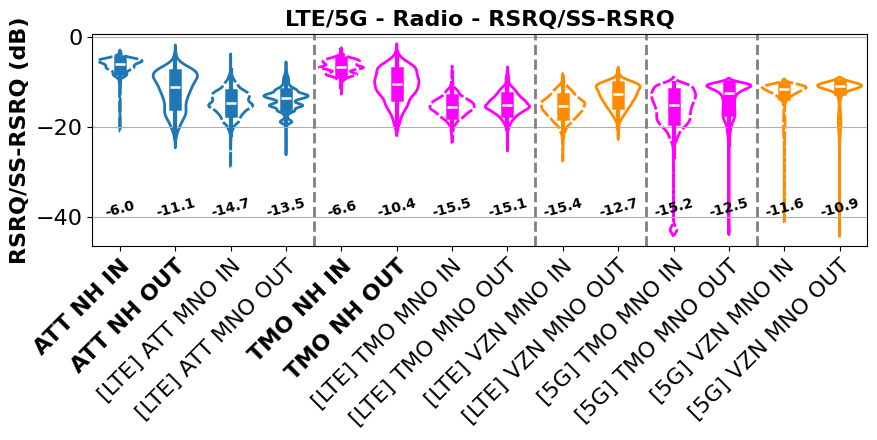

In [ ]:
# LTE/5G - Radio - RSRQ/SS-RSRQ
fig, ax = plt.subplots(figsize=(10, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_radio_att_nh_in.assign(Collection_plot='ATT NH IN'),
    df_lte_radio_att_nh_out.assign(Collection_plot='ATT NH OUT'),
    df_lte_radio_att_mno_in.assign(Collection_plot='[LTE] ATT MNO IN'),
    df_lte_radio_att_mno_out.assign(Collection_plot='[LTE] ATT MNO OUT'),
    df_lte_radio_tmo_nh_in.assign(Collection_plot='TMO NH IN'),
    df_lte_radio_tmo_nh_out.assign(Collection_plot='TMO NH OUT'),
    df_lte_radio_tmo_mno_in.assign(Collection_plot='[LTE] TMO MNO IN'),
    df_lte_radio_tmo_mno_out.assign(Collection_plot='[LTE] TMO MNO OUT'),
    df_lte_radio_vzn_mno_in.assign(Collection_plot='[LTE] VZN MNO IN'),
    df_lte_radio_vzn_mno_out.assign(Collection_plot='[LTE] VZN MNO OUT'),
    df_5g_radio_tmo_mno_in.rename(columns={'SS-RSRQ': 'RSRQ'}).assign(Collection_plot='[5G] TMO MNO IN'),
    df_5g_radio_tmo_mno_out.rename(columns={'SS-RSRQ': 'RSRQ'}).assign(Collection_plot='[5G] TMO MNO OUT'),
    df_5g_radio_vzn_mno_in.rename(columns={'SS-RSRQ': 'RSRQ'}).assign(Collection_plot='[5G] VZN MNO IN'),
    df_5g_radio_vzn_mno_out.rename(columns={'SS-RSRQ': 'RSRQ'}).assign(Collection_plot='[5G] VZN MNO OUT')
])
data = data.dropna(subset=['RSRQ'])
sns.violinplot(data=data, x='Collection_plot', y='RSRQ', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 14, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=3.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=7.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=9.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
medians = data.groupby('Collection_plot')['RSRQ'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, -40, f'{median_value:.1f}', horizontalalignment='center', color='black', fontsize=10, fontweight='bold', rotation=15)

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT NH IN', 'ATT NH OUT', 'TMO NH IN', 'TMO NH OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RSRQ/SS-RSRQ (dB)', fontsize=16, fontweight='bold')
plt.title('LTE/5G - Radio - RSRQ/SS-RSRQ', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/plot_radio_rsrq_all.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/plot_radio_rsrq_all.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

##### Plots: NH - In vs Out

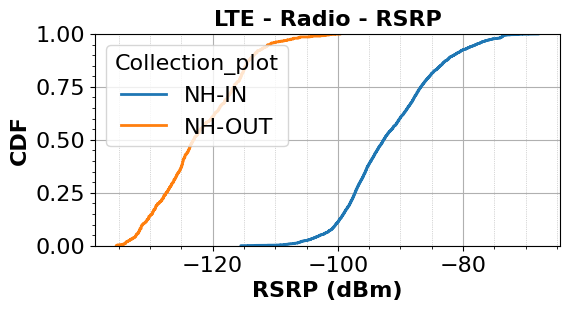

In [ ]:
# LTE - Radio - RSRP
fig, ax = plt.subplots(figsize=(6, 2.75))
data = pd.concat([
    df_lte_radio_att_nh_in.assign(Collection_plot='NH-IN'),
    df_lte_radio_att_nh_out.assign(Collection_plot='NH-OUT'),
    df_lte_radio_tmo_nh_in.assign(Collection_plot='NH-IN'),
    df_lte_radio_tmo_nh_out.assign(Collection_plot='NH-OUT'),
])
sns.ecdfplot(data=data, x='RSRP', hue='Collection_plot', ax=ax, linewidth=2)
plt.ylabel('CDF', fontsize=16, fontweight='bold')
plt.xlabel('RSRP (dBm)', fontsize=16, fontweight='bold')
plt.title('LTE - Radio - RSRP', fontsize=16, fontweight='bold')
plt.grid(True)
ax.minorticks_on()
ax.xaxis.grid(True, which='minor', linestyle=':', linewidth=0.5)
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/plot_radio_in_vs_out.pdf', bbox_inches='tight')
plt.show()
del fig, ax, data

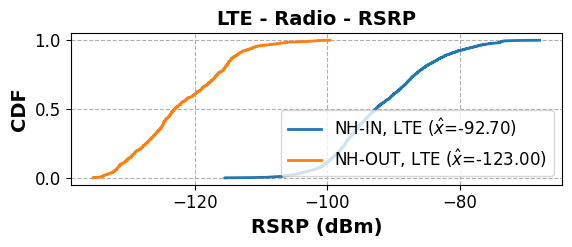

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2.75))
plt.rcParams['text.usetex'] = False 

df_temp = pd.concat([df_lte_radio_att_nh_in, df_lte_radio_tmo_nh_in])["RSRP"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"NH-IN, LTE ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='tab:blue')
del df_temp

df_temp = pd.concat([df_lte_radio_att_nh_out, df_lte_radio_tmo_nh_out])["RSRP"].dropna().sort_values()
ax.plot(df_temp,np.linspace(0, 1, df_temp.shape[0]),
    label=rf"NH-OUT, LTE ($\hat{{x}}$={df_temp.median():.2f})",
    markersize=12, linewidth=2, linestyle='solid', color='tab:orange')
del df_temp

ax.set_xlabel('RSRP (dBm)', fontsize=14, fontweight='bold')
ax.set_ylabel('CDF', fontsize=14, fontweight='bold')
plt.title('LTE - Radio - RSRP', fontsize=14, fontweight='bold')
ax.yaxis.set_minor_locator(AutoLocator())
ax.grid(True, linestyle='--', which='both', axis='both')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()
plt.show()

##### Plots: Band specific

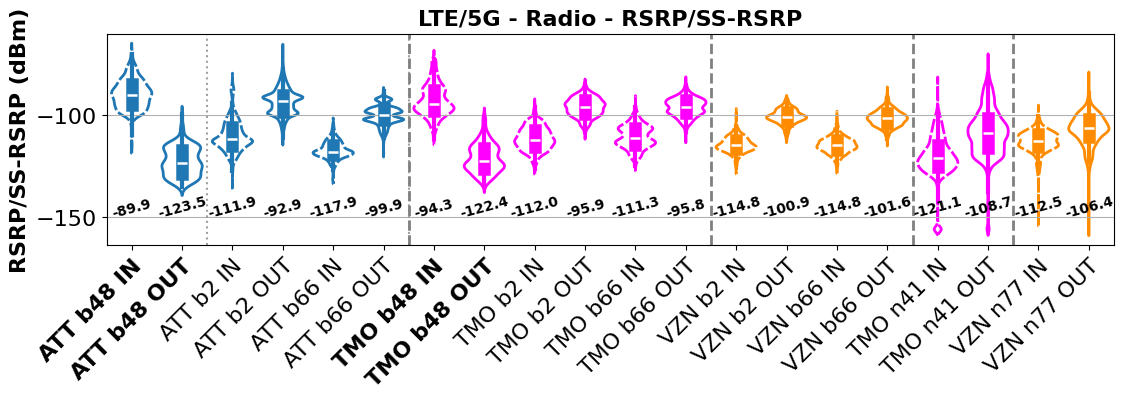

In [23]:
# LTE/5G - Radio - RSRP/SS-RSRP
fig, ax = plt.subplots(figsize=(13, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_radio_att_nh_in.assign(Collection_plot='ATT b48 IN'),
    df_lte_radio_att_nh_out.assign(Collection_plot='ATT b48 OUT'),
    df_lte_radio_att_mno_in[df_lte_radio_att_mno_in['Band Number']==2].assign(Collection_plot='ATT b2 IN'),
    df_lte_radio_att_mno_out[df_lte_radio_att_mno_out['Band Number']==2].assign(Collection_plot='ATT b2 OUT'),
    df_lte_radio_att_mno_in[df_lte_radio_att_mno_in['Band Number']==66].assign(Collection_plot='ATT b66 IN'),
    df_lte_radio_att_mno_out[df_lte_radio_att_mno_out['Band Number']==66].assign(Collection_plot='ATT b66 OUT'),
    df_lte_radio_tmo_nh_in.assign(Collection_plot='TMO b48 IN'),
    df_lte_radio_tmo_nh_out.assign(Collection_plot='TMO b48 OUT'),
    df_lte_radio_tmo_mno_in[df_lte_radio_tmo_mno_in['Band Number']==2].assign(Collection_plot='TMO b2 IN'),
    df_lte_radio_tmo_mno_out[df_lte_radio_tmo_mno_out['Band Number']==2].assign(Collection_plot='TMO b2 OUT'),
    df_lte_radio_tmo_mno_in[df_lte_radio_tmo_mno_in['Band Number']==66].assign(Collection_plot='TMO b66 IN'),
    df_lte_radio_tmo_mno_out[df_lte_radio_tmo_mno_out['Band Number']==66].assign(Collection_plot='TMO b66 OUT'),
    df_lte_radio_vzn_mno_in[df_lte_radio_vzn_mno_in['Band Number']==2].assign(Collection_plot='VZN b2 IN'),
    df_lte_radio_vzn_mno_out[df_lte_radio_vzn_mno_out['Band Number']==2].assign(Collection_plot='VZN b2 OUT'),
    df_lte_radio_vzn_mno_in[df_lte_radio_vzn_mno_in['Band Number']==66].assign(Collection_plot='VZN b66 IN'),
    df_lte_radio_vzn_mno_out[df_lte_radio_vzn_mno_out['Band Number']==66].assign(Collection_plot='VZN b66 OUT'),
    df_5g_radio_tmo_mno_in[df_5g_radio_tmo_mno_in['Band Number']==41].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 IN'),
    df_5g_radio_tmo_mno_out[df_5g_radio_tmo_mno_out['Band Number']==41].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 OUT'),
    df_5g_radio_vzn_mno_in[df_5g_radio_vzn_mno_in['Band Number']==77].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 IN'),
    df_5g_radio_vzn_mno_out[df_5g_radio_vzn_mno_out['Band Number']==77].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 OUT'),
])
sns.violinplot(data=data, x='Collection_plot', y='RSRP', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 20, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=15.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=17.5, color='gray', linestyle='--', linewidth=2)

plt.axvline(x=1.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=5.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
medians = data.groupby('Collection_plot')['RSRP'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, -150, f'{median_value:.1f}', horizontalalignment='center', color='black', fontsize=10, fontweight='bold', rotation=15)

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RSRP/SS-RSRP (dBm)', fontsize=16, fontweight='bold')
plt.title('LTE/5G - Radio - RSRP/SS-RSRP', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

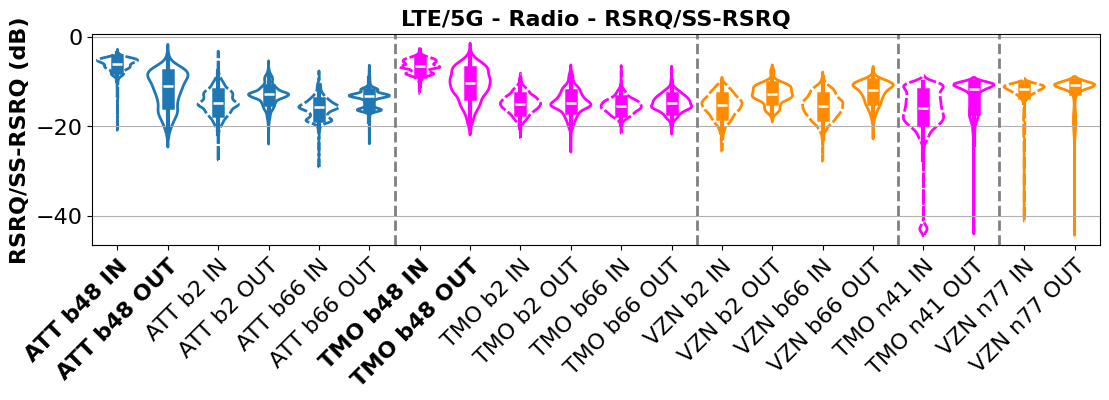

In [24]:
# LTE/5G - Radio - RSRQ/SS-RSRQ
fig, ax = plt.subplots(figsize=(13, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_radio_att_nh_in.assign(Collection_plot='ATT b48 IN'),
    df_lte_radio_att_nh_out.assign(Collection_plot='ATT b48 OUT'),
    df_lte_radio_att_mno_in[df_lte_radio_att_mno_in['Band Number']==2].assign(Collection_plot='ATT b2 IN'),
    df_lte_radio_att_mno_out[df_lte_radio_att_mno_out['Band Number']==2].assign(Collection_plot='ATT b2 OUT'),
    df_lte_radio_att_mno_in[df_lte_radio_att_mno_in['Band Number']==66].assign(Collection_plot='ATT b66 IN'),
    df_lte_radio_att_mno_out[df_lte_radio_att_mno_out['Band Number']==66].assign(Collection_plot='ATT b66 OUT'),
    df_lte_radio_tmo_nh_in.assign(Collection_plot='TMO b48 IN'),
    df_lte_radio_tmo_nh_out.assign(Collection_plot='TMO b48 OUT'),
    df_lte_radio_tmo_mno_in[df_lte_radio_tmo_mno_in['Band Number']==2].assign(Collection_plot='TMO b2 IN'),
    df_lte_radio_tmo_mno_out[df_lte_radio_tmo_mno_out['Band Number']==2].assign(Collection_plot='TMO b2 OUT'),
    df_lte_radio_tmo_mno_in[df_lte_radio_tmo_mno_in['Band Number']==66].assign(Collection_plot='TMO b66 IN'),
    df_lte_radio_tmo_mno_out[df_lte_radio_tmo_mno_out['Band Number']==66].assign(Collection_plot='TMO b66 OUT'),
    df_lte_radio_vzn_mno_in[df_lte_radio_vzn_mno_in['Band Number']==2].assign(Collection_plot='VZN b2 IN'),
    df_lte_radio_vzn_mno_out[df_lte_radio_vzn_mno_out['Band Number']==2].assign(Collection_plot='VZN b2 OUT'),
    df_lte_radio_vzn_mno_in[df_lte_radio_vzn_mno_in['Band Number']==66].assign(Collection_plot='VZN b66 IN'),
    df_lte_radio_vzn_mno_out[df_lte_radio_vzn_mno_out['Band Number']==66].assign(Collection_plot='VZN b66 OUT'),
    df_5g_radio_tmo_mno_in[df_5g_radio_tmo_mno_in['Band Number']==41].rename(columns={'SS-RSRQ': 'RSRQ'}).assign(Collection_plot='TMO n41 IN'),
    df_5g_radio_tmo_mno_out[df_5g_radio_tmo_mno_out['Band Number']==41].rename(columns={'SS-RSRQ': 'RSRQ'}).assign(Collection_plot='TMO n41 OUT'),
    df_5g_radio_vzn_mno_in[df_5g_radio_vzn_mno_in['Band Number']==77].rename(columns={'SS-RSRQ': 'RSRQ'}).assign(Collection_plot='VZN n77 IN'),
    df_5g_radio_vzn_mno_out[df_5g_radio_vzn_mno_out['Band Number']==77].rename(columns={'SS-RSRQ': 'RSRQ'}).assign(Collection_plot='VZN n77 OUT'),
])
sns.violinplot(data=data.dropna(subset=['RSRQ']), x='Collection_plot', y='RSRQ', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 20, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=15.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=17.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RSRQ/SS-RSRQ (dB)', fontsize=16, fontweight='bold')
plt.title('LTE/5G - Radio - RSRQ/SS-RSRQ', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

##### print(): PCI statistics

Summary of Representative PCIs:

NH IN - AP 1 - PCI 4,7

NH OUT - AP 6 - PCI 8,15

ATT b2,66 - PCI 77

TMO b2 - PCI 231

TMO b66 - PCI 294

VZN b2,66 - PCI 357

TMO n41 - PCI 681

VZN n77 - PCI 357

In [25]:
print('LTE ATT NH IN')
print(df_lte_radio_att_nh_in[['Band Number', 'PCI LTE']].value_counts().sort_index())
print('LTE ATT NH OUT')
print(df_lte_radio_att_nh_out[['Band Number', 'PCI LTE']].value_counts().sort_index())
print('LTE ATT MNO IN')
print(df_lte_radio_att_mno_in[['Band Number', 'PCI LTE']].value_counts().sort_index())
print('LTE ATT MNO OUT')
print(df_lte_radio_att_mno_out[['Band Number', 'PCI LTE']].value_counts().sort_index())

LTE ATT NH IN
Band Number  PCI LTE
48           4          198
             5          171
             7          193
             8          135
             9           45
             13         238
             15         133
             16         231
             20          51
             21          66
             23         182
             25          71
Name: count, dtype: int64
LTE ATT NH OUT
Band Number  PCI LTE
48           4          149
             7          156
             8           79
             13           3
             15          80
             16           3
             21          27
             25          27
Name: count, dtype: int64
LTE ATT MNO IN
Band Number  PCI LTE
2            77         2614
             80          332
             149          11
             422         379
             430        1097
12           77         1091
             80           26
             81          162
             149           9
             422    

In [26]:
print('LTE TMO NH IN')
print(df_lte_radio_tmo_nh_in[['Band Number', 'PCI LTE']].value_counts().sort_index())
print('LTE TMO NH OUT')
print(df_lte_radio_tmo_nh_out[['Band Number', 'PCI LTE']].value_counts().sort_index())
print('LTE TMO MNO IN')
print(df_lte_radio_tmo_mno_in[['Band Number', 'PCI LTE']].value_counts().sort_index())
print('LTE TMO MNO OUT')
print(df_lte_radio_tmo_mno_out[['Band Number', 'PCI LTE']].value_counts().sort_index())

LTE TMO NH IN
Band Number  PCI LTE
48           4          514
             5          318
             7          512
             8          142
             9           57
             13         373
             15         141
             16         370
             20          55
             21         105
             23         320
             25         108
Name: count, dtype: int64
LTE TMO NH OUT
Band Number  PCI LTE
48           4          129
             5            8
             7          129
             8           99
             15          97
             23           7
Name: count, dtype: int64
LTE TMO MNO IN
Band Number  PCI LTE
2            231         916
             462         774
12           252         419
             306         195
66           294         790
             330        1045
Name: count, dtype: int64
LTE TMO MNO OUT
Band Number  PCI LTE
2            231        374
             462        584
             494          9
12           252

In [27]:
print('LTE VZN MNO IN')
print(df_lte_radio_vzn_mno_in[['Band Number', 'PCI LTE']].value_counts().sort_index())
print('LTE VZN MNO OUT')
print(df_lte_radio_vzn_mno_out[['Band Number', 'PCI LTE']].value_counts().sort_index())

LTE VZN MNO IN
Band Number  PCI LTE
2            155          36
             318          19
             357        2066
5            357        1359
             389          10
13           125         407
             155         144
             318          80
             357         717
66           125         132
             155          10
             318         155
             357        4043
Name: count, dtype: int64
LTE VZN MNO OUT
Band Number  PCI LTE
2            357         333
13           125        1073
             357         331
66           125        1554
             357        1333
Name: count, dtype: int64


In [28]:
print('5G TMO MNO IN')
print(df_5g_radio_tmo_mno_in[['Band Number', 'PCI 5G NR']].value_counts().sort_index())
print('5G TMO MNO OUT')
print(df_5g_radio_tmo_mno_out[['Band Number', 'PCI 5G NR']].value_counts().sort_index())
print('5G VZN MNO IN')
print(df_5g_radio_vzn_mno_in[['Band Number', 'PCI 5G NR']].value_counts().sort_index())
print('5G VZN MNO OUT')
print(df_5g_radio_vzn_mno_out[['Band Number', 'PCI 5G NR']].value_counts().sort_index())

5G TMO MNO IN
Band Number  PCI 5G NR
25.0         16            256
             24             36
             137           534
             257            20
             286             7
                          ... 
71.0         771          2057
             808             2
             817             3
             852           152
             860             1
Name: count, Length: 62, dtype: int64
5G TMO MNO OUT
Band Number  PCI 5G NR
25.0         16               4
             137            729
             447           3500
             585           3518
41.0         87             334
             150              1
             188            864
             211             72
             228              5
             257              1
             302            193
             328           1146
             353             42
             381              4
             422              3
             447              1
             530             77
  

##### Plots: PCI specific

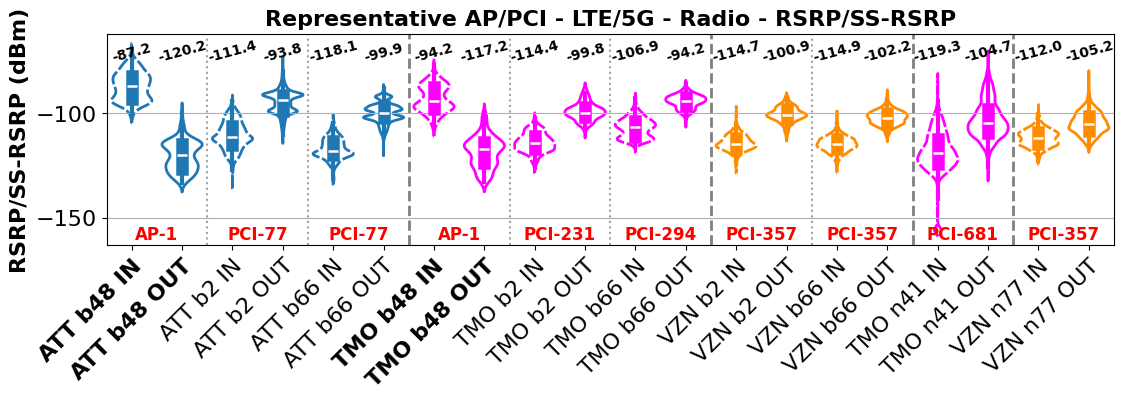

In [29]:
# LTE/5G - Radio - RSRP/SS-RSRP
fig, ax = plt.subplots(figsize=(13, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_radio_att_nh_in[df_lte_radio_att_nh_in['PCI LTE'].isin([4, 7])].assign(Collection_plot='ATT b48 IN'),
    df_lte_radio_att_nh_out[df_lte_radio_att_nh_out['PCI LTE'].isin([4, 7])].assign(Collection_plot='ATT b48 OUT'),
    df_lte_radio_att_mno_in[(df_lte_radio_att_mno_in['Band Number'] == 2) & (df_lte_radio_att_mno_in['PCI LTE'] == 77)].assign(Collection_plot='ATT b2 IN'),
    df_lte_radio_att_mno_out[(df_lte_radio_att_mno_out['Band Number'] == 2) & (df_lte_radio_att_mno_out['PCI LTE'] == 77)].assign(Collection_plot='ATT b2 OUT'),
    df_lte_radio_att_mno_in[(df_lte_radio_att_mno_in['Band Number'] == 66) & (df_lte_radio_att_mno_in['PCI LTE'] == 77)].assign(Collection_plot='ATT b66 IN'),
    df_lte_radio_att_mno_out[(df_lte_radio_att_mno_out['Band Number'] == 66) & (df_lte_radio_att_mno_out['PCI LTE'] == 77)].assign(Collection_plot='ATT b66 OUT'),
    df_lte_radio_tmo_nh_in[df_lte_radio_tmo_nh_in['PCI LTE'].isin([4, 7])].assign(Collection_plot='TMO b48 IN'),
    df_lte_radio_tmo_nh_out[df_lte_radio_tmo_nh_out['PCI LTE'].isin([4, 7])].assign(Collection_plot='TMO b48 OUT'),
    df_lte_radio_tmo_mno_in[(df_lte_radio_tmo_mno_in['Band Number']==2) & (df_lte_radio_tmo_mno_in['PCI LTE'] == 231)].assign(Collection_plot='TMO b2 IN'),
    df_lte_radio_tmo_mno_out[(df_lte_radio_tmo_mno_out['Band Number']==2) & (df_lte_radio_tmo_mno_out['PCI LTE'] == 231)].assign(Collection_plot='TMO b2 OUT'),
    df_lte_radio_tmo_mno_in[(df_lte_radio_tmo_mno_in['Band Number']==66) & (df_lte_radio_tmo_mno_in['PCI LTE'] == 294)].assign(Collection_plot='TMO b66 IN'),
    df_lte_radio_tmo_mno_out[(df_lte_radio_tmo_mno_out['Band Number']==66) & (df_lte_radio_tmo_mno_out['PCI LTE'] == 294)].assign(Collection_plot='TMO b66 OUT'),
    df_lte_radio_vzn_mno_in[(df_lte_radio_vzn_mno_in['Band Number'] == 2) & (df_lte_radio_vzn_mno_in['PCI LTE'] == 357)].assign(Collection_plot='VZN b2 IN'),
    df_lte_radio_vzn_mno_out[(df_lte_radio_vzn_mno_out['Band Number'] == 2) & (df_lte_radio_vzn_mno_out['PCI LTE'] == 357)].assign(Collection_plot='VZN b2 OUT'),
    df_lte_radio_vzn_mno_in[(df_lte_radio_vzn_mno_in['Band Number'] == 66) & (df_lte_radio_vzn_mno_in['PCI LTE'] == 357)].assign(Collection_plot='VZN b66 IN'),
    df_lte_radio_vzn_mno_out[(df_lte_radio_vzn_mno_out['Band Number'] == 66) & (df_lte_radio_vzn_mno_out['PCI LTE'] == 357)].assign(Collection_plot='VZN b66 OUT'),
    df_5g_radio_tmo_mno_in[(df_5g_radio_tmo_mno_in['Band Number']==41) & (df_5g_radio_tmo_mno_in['PCI 5G NR']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 IN'),
    df_5g_radio_tmo_mno_out[(df_5g_radio_tmo_mno_out['Band Number']==41) & (df_5g_radio_tmo_mno_out['PCI 5G NR']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='TMO n41 OUT'),
    df_5g_radio_vzn_mno_in[(df_5g_radio_vzn_mno_in['Band Number']==77) & (df_5g_radio_vzn_mno_in['PCI 5G NR']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 IN'),
    df_5g_radio_vzn_mno_out[(df_5g_radio_vzn_mno_out['Band Number']==77) & (df_5g_radio_vzn_mno_out['PCI 5G NR']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='VZN n77 OUT')
])
sns.violinplot(data=data, x='Collection_plot', y='RSRP', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 20, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=15.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=17.5, color='gray', linestyle='--', linewidth=2)

plt.axvline(x=1.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=3.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=7.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=9.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=13.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
ax.text(0.05, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.15, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.25, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.35, 0.05, 'AP-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.45, 0.05, 'PCI-231', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.55, 0.05, 'PCI-294', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.65, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.75, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.85, 0.05, 'PCI-681', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(0.95, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
medians = data.groupby('Collection_plot')['RSRP'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, -75, f'{median_value:.1f}', horizontalalignment='center', color='black', fontsize=10, fontweight='bold', rotation=15)

plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RSRP/SS-RSRP (dBm)', fontsize=16, fontweight='bold')
plt.title('Representative AP/PCI - LTE/5G - Radio - RSRP/SS-RSRP', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_64262/3761543186.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right')


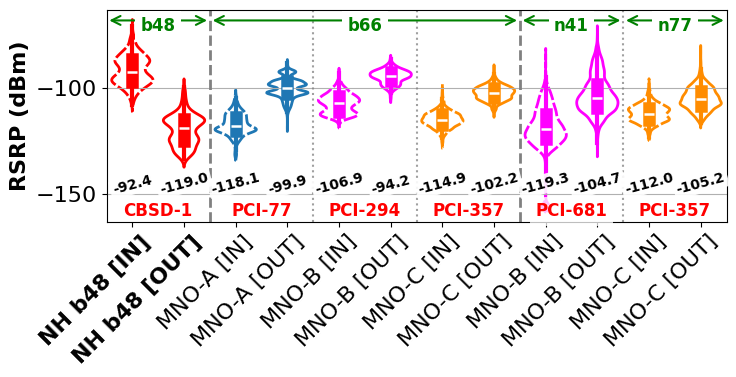

In [ ]:
fig, ax = plt.subplots(figsize=(8, 2.75))
palette = ['red', 'red', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    pd.concat([df_lte_radio_att_nh_in[df_lte_radio_att_nh_in['PCI LTE'].isin([4, 7])],df_lte_radio_tmo_nh_in[df_lte_radio_tmo_nh_in['PCI LTE'].isin([4, 7])]]).assign(Collection_plot='NH b48 [IN]'),
    pd.concat([df_lte_radio_att_nh_out[df_lte_radio_att_nh_out['PCI LTE'].isin([4, 7])],df_lte_radio_tmo_nh_out[df_lte_radio_tmo_nh_out['PCI LTE'].isin([4, 7])]]).assign(Collection_plot='NH b48 [OUT]'),
    df_lte_radio_att_mno_in[(df_lte_radio_att_mno_in['Band Number'] == 66) & (df_lte_radio_att_mno_in['PCI LTE'] == 77)].assign(Collection_plot='MNO-A b66 [IN]'),
    df_lte_radio_att_mno_out[(df_lte_radio_att_mno_out['Band Number'] == 66) & (df_lte_radio_att_mno_out['PCI LTE'] == 77)].assign(Collection_plot='MNO-A b66 [OUT]'),
    df_lte_radio_tmo_mno_in[(df_lte_radio_tmo_mno_in['Band Number']==66) & (df_lte_radio_tmo_mno_in['PCI LTE'] == 294)].assign(Collection_plot='MNO-B b66 [IN]'),
    df_lte_radio_tmo_mno_out[(df_lte_radio_tmo_mno_out['Band Number']==66) & (df_lte_radio_tmo_mno_out['PCI LTE'] == 294)].assign(Collection_plot='MNO-B b66 [OUT]'),
    df_lte_radio_vzn_mno_in[(df_lte_radio_vzn_mno_in['Band Number'] == 66) & (df_lte_radio_vzn_mno_in['PCI LTE'] == 357)].assign(Collection_plot='MNO-C b66 [IN]'),
    df_lte_radio_vzn_mno_out[(df_lte_radio_vzn_mno_out['Band Number'] == 66) & (df_lte_radio_vzn_mno_out['PCI LTE'] == 357)].assign(Collection_plot='MNO-C b66 [OUT]'),
    df_5g_radio_tmo_mno_in[(df_5g_radio_tmo_mno_in['Band Number']==41) & (df_5g_radio_tmo_mno_in['PCI 5G NR']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='MNO-B n41 [IN]'),
    df_5g_radio_tmo_mno_out[(df_5g_radio_tmo_mno_out['Band Number']==41) & (df_5g_radio_tmo_mno_out['PCI 5G NR']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='MNO-B n41 [OUT]'),
    df_5g_radio_vzn_mno_in[(df_5g_radio_vzn_mno_in['Band Number']==77) & (df_5g_radio_vzn_mno_in['PCI 5G NR']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='MNO-C n77 [IN]'),
    df_5g_radio_vzn_mno_out[(df_5g_radio_vzn_mno_out['Band Number']==77) & (df_5g_radio_vzn_mno_out['PCI 5G NR']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='MNO-C n77 [OUT]')
])
sns.violinplot(data=data, x='Collection_plot', y='RSRP', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)

new_labels = ['NH b48 [IN]', 'NH b48 [OUT]', 'MNO-A [IN]', 'MNO-A [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]']
ax.set_xticklabels(new_labels, rotation=45, ha='right')

for i in range(0, 12, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines

medians = data.groupby('Collection_plot')['RSRP'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, -150, f'{medians[collection]:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

plt.axvline(x=1.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=7.5, color='gray', linestyle='--', linewidth=2)

plt.axvline(x=3.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=5.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=9.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)

ax.text(1/12, 0.05, 'CBSD-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(1/12+2/12, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(1/12+4/12, 0.05, 'PCI-294', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(1/12+6/12, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(1/12+8/12, 0.05, 'PCI-681', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.75))
ax.text(1/12+10/12, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')

plt.xticks(rotation=45, ha='right')
dx = 15 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)

ax.annotate(
    '', xy=(-0.5, 0.95), xytext=(1.5, 0.95),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(1/12, 0.925, 'b48', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

ax.annotate(
    '', xy=(1.5, 0.95), xytext=(7.5, 0.95),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(5/12, 0.925, 'b66', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

ax.annotate(
    '', xy=(7.5, 0.95), xytext=(9.5, 0.95),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(9/12, 0.925, 'n41', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

ax.annotate(
    '', xy=(9.5, 0.95), xytext=(11.5, 0.95),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(11/12, 0.925, 'n77', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['NH b48 [IN]', 'NH b48 [OUT]']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RSRP (dBm)', fontsize=16, fontweight='bold')
# plt.title('Representative AP/PCI - LTE/5G - Radio - RSRP/SS-RSRP', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/radio_pci_rsrp.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_64262/1494641181.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, rotation=45, ha='right')


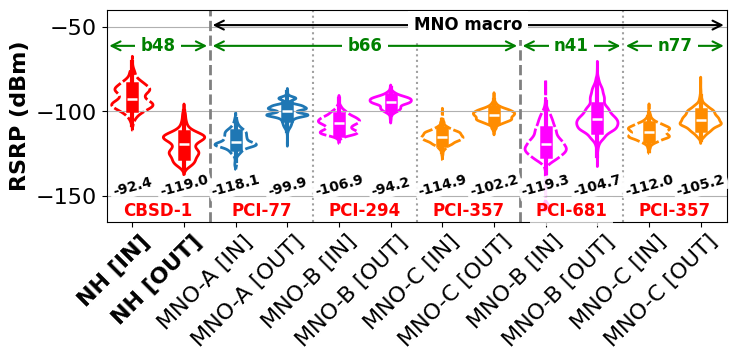

In [55]:
fig, ax = plt.subplots(figsize=(8, 2.75))
palette = ['red', 'red', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    pd.concat([df_lte_radio_att_nh_in[df_lte_radio_att_nh_in['PCI LTE'].isin([4, 7])],df_lte_radio_tmo_nh_in[df_lte_radio_tmo_nh_in['PCI LTE'].isin([4, 7])]]).assign(Collection_plot='NH b48 [IN]'),
    pd.concat([df_lte_radio_att_nh_out[df_lte_radio_att_nh_out['PCI LTE'].isin([4, 7])],df_lte_radio_tmo_nh_out[df_lte_radio_tmo_nh_out['PCI LTE'].isin([4, 7])]]).assign(Collection_plot='NH b48 [OUT]'),
    df_lte_radio_att_mno_in[(df_lte_radio_att_mno_in['Band Number'] == 66) & (df_lte_radio_att_mno_in['PCI LTE'] == 77)].assign(Collection_plot='MNO-A b66 [IN]'),
    df_lte_radio_att_mno_out[(df_lte_radio_att_mno_out['Band Number'] == 66) & (df_lte_radio_att_mno_out['PCI LTE'] == 77)].assign(Collection_plot='MNO-A b66 [OUT]'),
    df_lte_radio_tmo_mno_in[(df_lte_radio_tmo_mno_in['Band Number']==66) & (df_lte_radio_tmo_mno_in['PCI LTE'] == 294)].assign(Collection_plot='MNO-B b66 [IN]'),
    df_lte_radio_tmo_mno_out[(df_lte_radio_tmo_mno_out['Band Number']==66) & (df_lte_radio_tmo_mno_out['PCI LTE'] == 294)].assign(Collection_plot='MNO-B b66 [OUT]'),
    df_lte_radio_vzn_mno_in[(df_lte_radio_vzn_mno_in['Band Number'] == 66) & (df_lte_radio_vzn_mno_in['PCI LTE'] == 357)].assign(Collection_plot='MNO-C b66 [IN]'),
    df_lte_radio_vzn_mno_out[(df_lte_radio_vzn_mno_out['Band Number'] == 66) & (df_lte_radio_vzn_mno_out['PCI LTE'] == 357)].assign(Collection_plot='MNO-C b66 [OUT]'),
    df_5g_radio_tmo_mno_in[(df_5g_radio_tmo_mno_in['Band Number']==41) & (df_5g_radio_tmo_mno_in['PCI 5G NR']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='MNO-B n41 [IN]'),
    df_5g_radio_tmo_mno_out[(df_5g_radio_tmo_mno_out['Band Number']==41) & (df_5g_radio_tmo_mno_out['PCI 5G NR']==681)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='MNO-B n41 [OUT]'),
    df_5g_radio_vzn_mno_in[(df_5g_radio_vzn_mno_in['Band Number']==77) & (df_5g_radio_vzn_mno_in['PCI 5G NR']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='MNO-C n77 [IN]'),
    df_5g_radio_vzn_mno_out[(df_5g_radio_vzn_mno_out['Band Number']==77) & (df_5g_radio_vzn_mno_out['PCI 5G NR']==357)].rename(columns={'SS-RSRP': 'RSRP'}).assign(Collection_plot='MNO-C n77 [OUT]')
])
sns.violinplot(data=data, x='Collection_plot', y='RSRP', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)

new_labels = ['NH [IN]', 'NH [OUT]', 'MNO-A [IN]', 'MNO-A [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]', 'MNO-B [IN]', 'MNO-B [OUT]', 'MNO-C [IN]', 'MNO-C [OUT]']
ax.set_xticklabels(new_labels, rotation=45, ha='right')

for i in range(0, 12, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines

medians = data.groupby('Collection_plot')['RSRP'].median()
for i, collection in enumerate(data['Collection_plot'].unique()):
    median_value = medians[collection]
    ax.text(i, -150, f'{medians[collection]:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

plt.axvline(x=1.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=7.5, color='gray', linestyle='--', linewidth=2)

plt.axvline(x=3.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=5.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)
plt.axvline(x=9.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.75)

ax.text(1/12, 0.05, 'CBSD-1', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(1/12+2/12, 0.05, 'PCI-77', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(1/12+4/12, 0.05, 'PCI-294', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(1/12+6/12, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')
ax.text(1/12+8/12, 0.05, 'PCI-681', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none', alpha=0.75))
ax.text(1/12+10/12, 0.05, 'PCI-357', transform=ax.transAxes, fontsize=12, fontweight='bold', color='red', verticalalignment='center', horizontalalignment='center')

plt.xticks(rotation=45, ha='right')
dx = 15 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)

ax.annotate(
    '', xy=(1.5, 0.928), xytext=(11.5, 0.928),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='black', lw=1.5),
)
ax.text(7/12, 0.928, 'MNO macro', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='black',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))


ax.annotate(
    '', xy=(-0.5, 0.83), xytext=(1.5, 0.83),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(1/12, 0.83, 'b48', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

ax.annotate(
    '', xy=(1.5, 0.83), xytext=(7.5, 0.83),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(5/12, 0.83, 'b66', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

ax.annotate(
    '', xy=(7.5, 0.83), xytext=(9.5, 0.83),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(9/12, 0.83, 'n41', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

ax.annotate(
    '', xy=(9.5, 0.83), xytext=(11.5, 0.83),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(11/12, 0.83, 'n77', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['NH [IN]', 'NH [OUT]']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RSRP (dBm)', fontsize=16, fontweight='bold')
plt.ylim(-165, -40)
# plt.title('Representative AP/PCI - LTE/5G - Radio - RSRP/SS-RSRP', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/radio_pci_rsrp.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

In [32]:
%%script true
### NOT WORKING !!!

# LTE/5G - Radio - RSRQ/SS-RSRQ
fig, ax = plt.subplots(figsize=(13, 2.75))
palette = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'magenta', 'darkorange', 'darkorange', 'darkorange', 'darkorange', 'magenta', 'magenta', 'darkorange', 'darkorange']
data = pd.concat([
    df_lte_radio_att_nh_in[df_lte_radio_att_nh_in['PCI LTE'].isin([4, 7])].assign(Collection_plot='ATT b48 IN'),
    df_lte_radio_att_nh_out[df_lte_radio_att_nh_out['PCI LTE'].isin([4, 7])].assign(Collection_plot='ATT b48 OUT'),
    df_lte_radio_att_mno_in[(df_lte_radio_att_mno_in['Band Number'] == 2) & (df_lte_radio_att_mno_in['PCI LTE'] == 77)].assign(Collection_plot='ATT b2 IN'),
    df_lte_radio_att_mno_out[(df_lte_radio_att_mno_out['Band Number'] == 2) & (df_lte_radio_att_mno_out['PCI LTE'] == 77)].assign(Collection_plot='ATT b2 OUT'),
    df_lte_radio_att_mno_in[(df_lte_radio_att_mno_in['Band Number'] == 66) & (df_lte_radio_att_mno_in['PCI LTE'] == 77)].assign(Collection_plot='ATT b66 IN'),
    df_lte_radio_att_mno_out[(df_lte_radio_att_mno_out['Band Number'] == 66) & (df_lte_radio_att_mno_out['PCI LTE'] == 77)].assign(Collection_plot='ATT b66 OUT'),
    df_lte_radio_tmo_nh_in[df_lte_radio_tmo_nh_in['PCI LTE'].isin([4, 7])].assign(Collection_plot='TMO b48 IN'),
    df_lte_radio_tmo_nh_out[df_lte_radio_tmo_nh_out['PCI LTE'].isin([4, 7])].assign(Collection_plot='TMO b48 OUT'),
    df_lte_radio_tmo_mno_in[(df_lte_radio_tmo_mno_in['Band Number']==2) & (df_lte_radio_tmo_mno_in['PCI LTE'] == 231)].assign(Collection_plot='TMO b2 IN'),
    df_lte_radio_tmo_mno_out[(df_lte_radio_tmo_mno_out['Band Number']==2) & (df_lte_radio_tmo_mno_out['PCI LTE'] == 231)].assign(Collection_plot='TMO b2 OUT'),
    df_lte_radio_tmo_mno_in[(df_lte_radio_tmo_mno_in['Band Number']==66) & (df_lte_radio_tmo_mno_in['PCI LTE'] == 294)].assign(Collection_plot='TMO b66 IN'),
    df_lte_radio_tmo_mno_out[(df_lte_radio_tmo_mno_out['Band Number']==66) & (df_lte_radio_tmo_mno_out['PCI LTE'] == 294)].assign(Collection_plot='TMO b66 OUT'),
    df_lte_radio_vzn_mno_in[(df_lte_radio_vzn_mno_in['Band Number'] == 2) & (df_lte_radio_vzn_mno_in['PCI LTE'] == 357)].assign(Collection_plot='VZN b2 IN'),
    df_lte_radio_vzn_mno_out[(df_lte_radio_vzn_mno_out['Band Number'] == 2) & (df_lte_radio_vzn_mno_out['PCI LTE'] == 357)].assign(Collection_plot='VZN b2 OUT'),
    df_lte_radio_vzn_mno_in[(df_lte_radio_vzn_mno_in['Band Number'] == 66) & (df_lte_radio_vzn_mno_in['PCI LTE'] == 357)].assign(Collection_plot='VZN b66 IN'),
    df_lte_radio_vzn_mno_out[(df_lte_radio_vzn_mno_out['Band Number'] == 66) & (df_lte_radio_vzn_mno_out['PCI LTE'] == 357)].assign(Collection_plot='VZN b66 OUT'),
    df_5g_radio_tmo_mno_in[(df_5g_radio_tmo_mno_in['Band Number']==41) & (df_5g_radio_tmo_mno_in['PCI 5G NR']==681)].rename(columns={'SS-RSRQ': 'RSRQ'}).assign(Collection_plot='TMO n41 IN'),
    df_5g_radio_tmo_mno_out[(df_5g_radio_tmo_mno_out['Band Number']==41) & (df_5g_radio_tmo_mno_out['PCI 5G NR']==681)].rename(columns={'SS-RSRQ': 'RSRQ'}).assign(Collection_plot='TMO n41 OUT'),
    df_5g_radio_vzn_mno_in[(df_5g_radio_vzn_mno_in['Band Number']==77) & (df_5g_radio_vzn_mno_in['PCI 5G NR']==357)].rename(columns={'SS-RSRQ': 'RSRQ'}).assign(Collection_plot='VZN n77 IN'),
    df_5g_radio_vzn_mno_out[(df_5g_radio_vzn_mno_out['Band Number']==77) & (df_5g_radio_vzn_mno_out['PCI 5G NR']==357)].rename(columns={'SS-RSRQ': 'RSRP'}).assign(Collection_plot='VZN n77 OUT')
])
sns.violinplot(data=data.dropna(subset='RSRQ'), x='Collection_plot', y='RSRQ', hue='Collection_plot', palette=palette, fill=False, linewidth=2, ax=ax)
for i in range(0, 20, 2):
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=5.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=15.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=17.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['ATT b48 IN', 'ATT b48 OUT', 'TMO b48 IN', 'TMO b48 OUT']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RSRQ/SS-RSRQ (dB)', fontsize=16, fontweight='bold')
plt.title('Representative AP/PCI - LTE/5G - Radio - RSRQ/SS-RSRP', fontsize=16, fontweight='bold')
plt.grid(True, axis='y')
# plt.savefig('figs/josh_dl_tput_all_plot.png', bbox_inches='tight', dpi=300)
# plt.savefig('figs/josh_dl_tput_all_plot.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, data, palette, labels

In [41]:

# print('LTE ATT NH IN')
# print(df_lte_radio_att_nh_in[['Band Number', 'PCI LTE']].value_counts().sort_index())
# print('LTE ATT NH OUT')
# print(df_lte_radio_att_nh_out[['Band Number', 'PCI LTE']].value_counts().sort_index())
# print('LTE ATT MNO IN')
# print(df_lte_radio_att_mno_in[['Band Number', 'PCI LTE']].value_counts().sort_index())
# print('LTE ATT MNO OUT')
# print(df_lte_radio_att_mno_out[['Band Number', 'PCI LTE']].value_counts().sort_index())


# print('LTE ATT NH')
# print(pd.concat([df_lte_radio_att_nh_in[['Band Number', 'PCI LTE']].value_counts().sort_index(), df_lte_radio_att_nh_out[['Band Number', 'PCI LTE']].value_counts().sort_index()]).sort_index())
# print('LTE TMO NH')
# print(pd.concat([df_lte_radio_tmo_nh_in[['Band Number', 'PCI LTE']].value_counts().sort_index(), df_lte_radio_tmo_nh_out[['Band Number', 'PCI LTE']].value_counts().sort_index()]).sort_index())
# print('LTE ATT MNO')
# print(pd.concat([df_lte_radio_att_mno_in[['Band Number', 'PCI LTE']].value_counts().sort_index(), df_lte_radio_att_mno_out[['Band Number', 'PCI LTE']].value_counts().sort_index()]).sort_index())
# print('LTE TMO MNO')
# print(pd.concat([df_lte_radio_tmo_mno_in[['Band Number', 'PCI LTE']].value_counts().sort_index(), df_lte_radio_tmo_mno_out[['Band Number', 'PCI LTE']].value_counts().sort_index()]).sort_index())
# print('LTE VZN MNO')
# print(pd.concat([df_lte_radio_vzn_mno_in[['Band Number', 'PCI LTE']].value_counts().sort_index(), df_lte_radio_vzn_mno_out[['Band Number', 'PCI LTE']].value_counts().sort_index()]).sort_index())
# print('5G TMO MNO')
# print(pd.concat([df_5g_radio_tmo_mno_in[['Band Number', 'PCI 5G NR']].value_counts().sort_index(), df_5g_radio_tmo_mno_out[['Band Number', 'PCI 5G NR']].value_counts().sort_index()]).sort_index())
# print('5G VZN MNO')
# print(pd.concat([df_5g_radio_vzn_mno_in[['Band Number', 'PCI 5G NR']].value_counts().sort_index(), df_5g_radio_vzn_mno_out[['Band Number', 'PCI 5G NR']].value_counts().sort_index()]).sort_index())